---
<span style="color:#000; font-family: 'Bebas Neue'; font-size: 2em;">Machine Learning III  Unsupervised and Network Analysis</span>

<span style="color:#f00; font-family: 'Bebas Neue'; font-size: 1.5em;">EXAMEN FINAL - PARTE III (3 puntos)</span>
<h4 style="color:darkblue"> Universidad Pontificia Comillas</h4>
<img src="https://upload.wikimedia.org/wikipedia/commons/e/e4/Comillas_Universidad_Pontificia_logo_%282018%29.jpg" alt="drawing" style="width:200px;"/>
<h5 style="color:black">  7 Abril 2024 - Madrid </h5>
<h5 style="color:gray"> Prof. María del Valle Varo García </h5>

---

`Yago Tobio Souto`

----

### **Problema 3a: Amazon Office**

1. Load the `amazon office` dataset from cornac and compare for K=50 the models PMF and MF. 
2. Find the best value of $\lambda_{C}$ (1 to 100) for a SoRec model of K=50, using rmse and ndcg metrics.
3. Make a plot of RMSE vs  $\lambda_{C}$.
4. From the graph connections, plot 50 interactions of this dataset.


---


**Librerías**

In [2]:
# Standard library imports
import itertools
import math
import os
import sys
import time
import warnings
from collections import defaultdict

# Data manipulation and numerical libraries
import numpy as np
import pandas as pd
from scipy import sparse as sp, stats
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.sparse.linalg import svds
from scipy.special import softmax
from scipy.stats import multivariate_normal

# Text and natural language processing
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Machine Learning and Data Science libraries
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error, silhouette_samples, silhouette_score
from sklearn.metrics.cluster import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    rand_score,
)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import RocCurveDisplay

# Graph and plot libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.cbook import boxplot_stats
from matplotlib.ticker import FixedLocator, FixedFormatter
import seaborn as sns
import plotly.express as px

# Deep Learning libraries
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset

# Transformer models
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

# Utility and other specific tools
from adjustText import adjust_text
from tabulate import tabulate
from tqdm.notebook import tqdm

# Recommender systems and specific utilities
import cornac
from cornac.data.text import BaseTokenizer
from cornac.data import GraphModality, ImageModality, TextModality, text as cornac_text
from cornac.datasets import amazon_clothing, filmtrust, movielens
from cornac.eval_methods import RatioSplit
from cornac.models import (
    BPR,
    BaselineOnly,
    CTR,
    ItemKNN,
    MF,
    NMF,
    PMF,
    SVD,
    SoRec,
    UserKNN,
    VBPR,
    WMF,
)
from cornac.utils import cache

# from cornac.datasets.python_splitters import python_random_split
# from cornac.models.cornac.cornac_utils import predict_ranking

# Elasticsearch
from elasticsearch import Elasticsearch, helpers

# from recommenders.utils.timer import Timer
# from recommenders.datasets import movielens
# from recommenders.utils.notebook_utils import store_metadata
# from recommenders.models.recommenders.utils.constants import SEED
# from recommenders.datasets.python_splitters import python_random_split
# from recommenders.evaluation.python_evaluation import (
#    map,
#    ndcg_at_k,
#    precision_at_k,
#    recall_at_k,
# )

# Constants and configurations
SEED = 42
VERBOSE = False
pd.set_option("max_colwidth", 0)
%matplotlib inline

# Printing versions of libraries
print(f"System version: {sys.version}")
print(f"Cornac version: {cornac.__version__}")
print(f"TensorFlow version: {tf.__version__}")

System version: 3.12.3 (v3.12.3:f6650f9ad7, Apr  9 2024, 08:18:47) [Clang 13.0.0 (clang-1300.0.29.30)]
Cornac version: 2.1
TensorFlow version: 2.16.1


----

**Pregunta 3a - 1:**
Load the `amazon office` dataset from cornac and compare for K=50 the models PMF and MF. 

In [13]:
from cornac.datasets import amazon_office as office

# MCF leverages relationships among items, it jointly factorizes the user-item and item-item matrices
# The necessary data can be loaded as follows
ratings = office.load_feedback()
# item_net = office.load_graph()
ratings

[('200', '1', 5.0),
 ('1234', '1', 5.0),
 ('1353', '1', 5.0),
 ('1640', '2', 4.0),
 ('200', '2', 5.0),
 ('1330', '3', 5.0),
 ('760', '3', 2.0),
 ('1179', '4', 4.0),
 ('350', '4', 5.0),
 ('3588', '5', 5.0),
 ('3153', '5', 5.0),
 ('3588', '6', 5.0),
 ('3472', '6', 5.0),
 ('3588', '7', 5.0),
 ('3153', '7', 5.0),
 ('3588', '8', 5.0),
 ('3472', '8', 5.0),
 ('3153', '8', 5.0),
 ('3472', '9', 5.0),
 ('3153', '9', 5.0),
 ('3588', '10', 5.0),
 ('3153', '10', 5.0),
 ('3588', '11', 5.0),
 ('3472', '11', 5.0),
 ('3588', '12', 5.0),
 ('3472', '12', 5.0),
 ('3153', '12', 5.0),
 ('3588', '13', 5.0),
 ('3472', '13', 5.0),
 ('3153', '13', 5.0),
 ('3472', '14', 5.0),
 ('3153', '14', 5.0),
 ('3588', '15', 5.0),
 ('3472', '15', 5.0),
 ('3153', '15', 5.0),
 ('3472', '16', 5.0),
 ('3153', '16', 5.0),
 ('188', '17', 4.0),
 ('2096', '17', 4.0),
 ('640', '18', 5.0),
 ('2518', '18', 5.0),
 ('260', '19', 4.0),
 ('1789', '19', 5.0),
 ('1538', '20', 5.0),
 ('395', '20', 5.0),
 ('1825', '21', 5.0),
 ('94', '21', 5.

In [6]:
K = 50
# * Definition of the SoRec Model
mf = MF(
    k=K,
    max_iter=50,
    learning_rate=0.01,
    lambda_reg=0.01,
    use_bias=False,
    verbose=VERBOSE,
    seed=SEED,
    name=f"MF(K={K},lambda={0.01:.4f})",
)
# * Definition of the PMF model
pmf = PMF(
    k=K, max_iter=50, learning_rate=0.001, lambda_reg=0.01, verbose=VERBOSE, seed=SEED
)

In [9]:
ratio_split = RatioSplit(ratings, test_size=0.2, seed=SEED, verbose=VERBOSE)
cornac.Experiment(
    eval_method=ratio_split,
    models=[mf, pmf],
    metrics=[cornac.metrics.RMSE()],
).run()

mf_models = {"mf": mf, "pmf": pmf}

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/cornac/models/recommender.py:306: UserWarning: Model is already fitted. Re-fitting will overwrite the previous model.
  warnings.warn(



TEST:
...
                       |   RMSE | Train (s) | Test (s)
---------------------- + ------ + --------- + --------
MF(K=50,lambda=0.0100) | 0.8900 |    0.0689 |   0.1960
PMF                    | 0.9585 |    1.6177 |   0.1817



> Podemos observar que en terminos de RMSE, Matrix Factorisation nos da un menor error que Probabilistic Matrix Factorisation para este dataset

**Pregunta 3a - 2:** Find the best value of $\lambda_{C}$ (1 to 100) for a SoRec model of K=50, using rmse and ndcg metrics.


In [14]:
trust = office.load_graph()
item_graph_modality = GraphModality(data=trust)

In [27]:
K = 50
rmse = cornac.metrics.RMSE()
ndcg = cornac.metrics.NDCG()  # Normalized Discount Cumulative Gain
# * Definition of the SoRec Model
ratio_split = RatioSplit(
    data=ratings,
    test_size=0.2,
    rating_threshold=2.5,
    exclude_unknowns=True,
    user_graph=item_graph_modality,
    verbose=VERBOSE,
    seed=SEED,
)

list = np.arange(1, 100, 10).tolist()
experiments_vec = []
for i in list:
    sorec = SoRec(
        k=K, max_iter=50, learning_rate=0.01, lambda_c=i, verbose=VERBOSE, seed=SEED
    )
    experiment = cornac.Experiment(
        eval_method=ratio_split, models=[sorec], metrics=[rmse, ndcg]
    )  # * RMSE ubicado aquí
    experiment.run()
    experiments_vec.append(experiment)


TEST:
...
      |   RMSE | NDCG@-1 | Train (s) | Test (s)
----- + ------ + ------- + --------- + --------
SoRec | 0.8967 |  0.1309 |    5.6964 |   4.6471


TEST:
...
      |   RMSE | NDCG@-1 | Train (s) | Test (s)
----- + ------ + ------- + --------- + --------
SoRec | 1.0224 |  0.1383 |    5.6965 |   4.9150


TEST:
...
      |   RMSE | NDCG@-1 | Train (s) | Test (s)
----- + ------ + ------- + --------- + --------
SoRec | 1.1001 |  0.1390 |    5.7943 |   4.7170


TEST:
...
      |   RMSE | NDCG@-1 | Train (s) | Test (s)
----- + ------ + ------- + --------- + --------
SoRec | 1.1925 |  0.1408 |    5.4857 |   6.6074


TEST:
...
      |   RMSE | NDCG@-1 | Train (s) | Test (s)
----- + ------ + ------- + --------- + --------
SoRec | 1.2879 |  0.1425 |    5.7133 |   5.9919


TEST:
...
      |   RMSE | NDCG@-1 | Train (s) | Test (s)
----- + ------ + ------- + --------- + --------
SoRec | 1.3664 |  0.1421 |    5.8428 |   5.2235


TEST:
...
      |   RMSE | NDCG@-1 | Train (s) | Test (s)
-----


**Pregunta 3a - 3:** Make a plot of RMSE vs $\lambda_c$


In [61]:
import statistics

rmse_vals = []
dict_values = []
for exp in experiments_vec:
    for r in exp.result:
        user_results = r.metric_user_results  # <- this is a dictionary
        rmse = user_results.get("RMSE")
        print(rmse)
        for k, v in rmse.items():
            dict_values.append(
                v
            )  # * Hacemos el average de todos los valores del RMSE del diccionario
        rmse_vals.append(statistics.mean(dict_values))

{0: 2.2938479550783666, 1: 1.6571485197277358, 2: 1.098564942071318, 3: 0.635904729419325, 4: 0.9469432103805129, 5: 1.031904730835927, 6: 0.555682504216197, 7: 0.682966722683327, 8: 0.7239824794986169, 9: 0.7724096978208334, 10: 0.5678586650737061, 11: 0.7331195931270443, 12: 0.9331166338431421, 13: 0.5255051213781193, 14: 1.7106134069658718, 15: 1.0211036713755608, 16: 0.2956439807349316, 17: 0.6657218680227409, 18: 2.392662254423446, 19: 0.6472289180341341, 21: 1.6273917011688557, 22: 0.6889644666922514, 23: 1.0159983463697204, 26: 0.9805704341501515, 27: 1.242433893805746, 29: 1.6964149997337359, 30: 0.36285196779711626, 31: 1.439953876087102, 32: 0.3727291239912933, 33: 0.5644887954597837, 34: 1.7596136459062217, 35: 1.0235321326855593, 36: 0.33541367763875274, 37: 0.6736126017105005, 38: 1.2461153862040288, 39: 0.8230087372247916, 40: 0.4855962087789383, 41: 0.9260710444093486, 42: 0.5268049017145602, 43: 0.7500397930588455, 44: 0.6204167765742775, 45: 0.7049881363396879, 46: 1.4

In [62]:
rmse_vals

[0.8967110497738495,
 0.95957623602219,
 1.0064151220874213,
 1.052941415707852,
 1.0999300624861406,
 1.1443394234333315,
 1.1896126438372867,
 1.2337618356378186,
 1.2695191473985412,
 1.3041297541927916]

Text(0.5, 1.0, 'Lambda_c vs. RMSE')

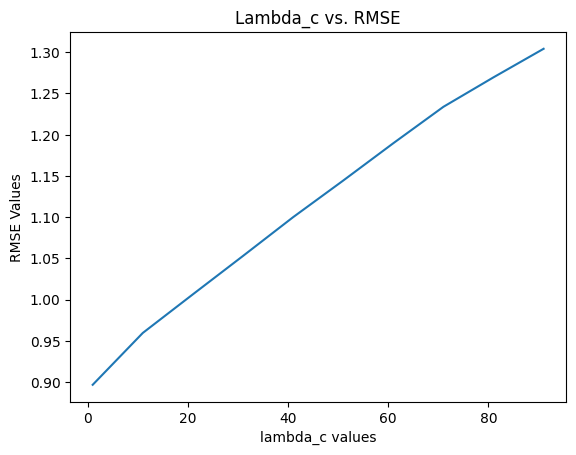

In [63]:
lambda_c = np.arange(1, 100, 10).tolist()

plt.plot(lambda_c, rmse_vals)
plt.xlabel("lambda_c values")  # add X-axis label
plt.ylabel("RMSE Values")  # add Y-axis label
plt.title("Lambda_c vs. RMSE")  # add title
# for item in experiments_vec:
#    print(item)

> Parece que cuant más bajo el lambda_c mejor es el sistema, por lo tanto $\lambda_c$ optimo es 1

**Pregunta 3a - 4:** From the graph connections, plot 50 interactions of this dataset.


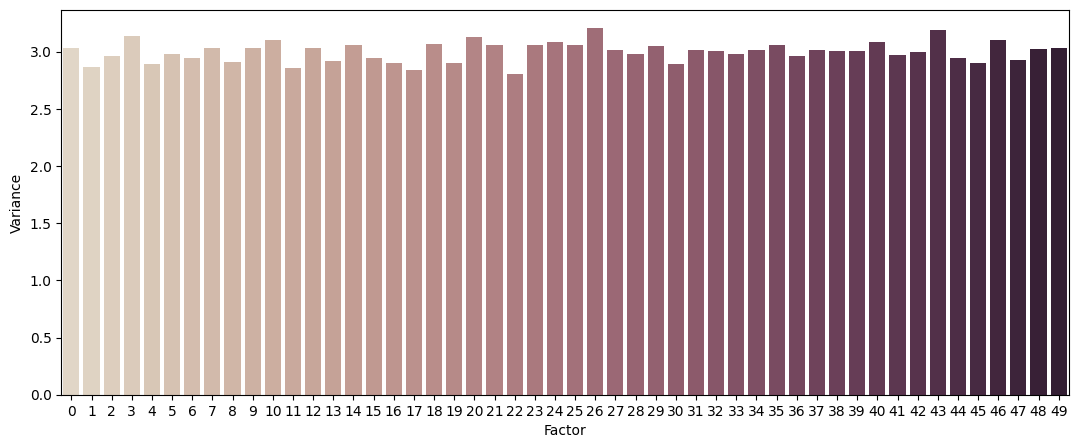

In [34]:
var_df = pd.DataFrame({"Factor": np.arange(K), "Variance": np.var(sorec.U, axis=0)})
fig, ax = plt.subplots(figsize=(13, 5))
# * Hacemos plot de los Factores vs. la varianza
sns.barplot(
    x="Factor",
    y="Variance",
    hue="Factor",
    data=var_df,
    palette="ch:.25",
    ax=ax,
    legend=False,
);

In [37]:
var_df.sort_values("Variance", ascending=False).head(5)

,Factor,Variance
26,26,3.206704
43,43,3.185980
3,3,3.133252
20,20,3.131319
10,10,3.102850


50 conexiones visualizadas


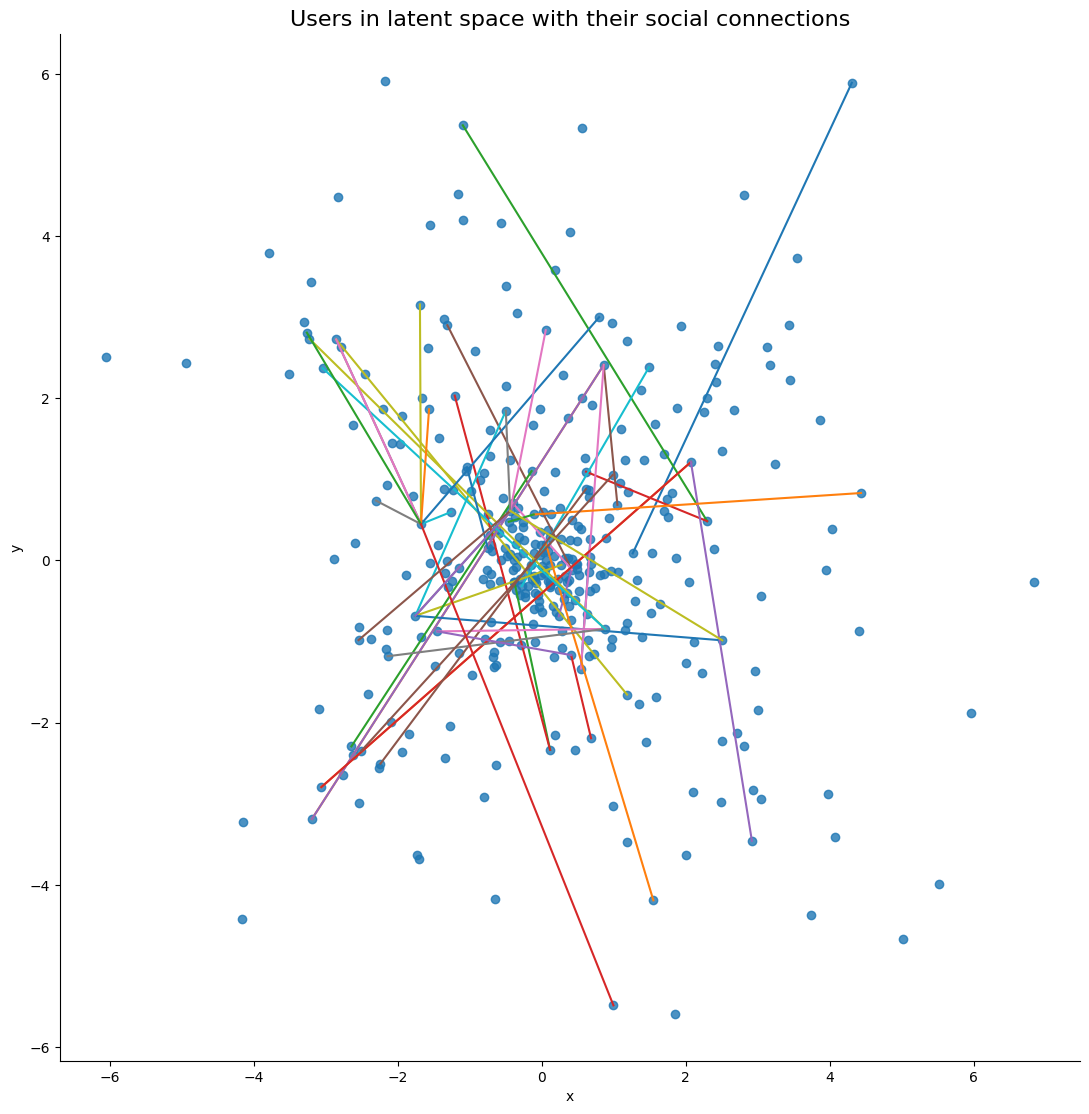

In [47]:
TOP2F = (
    26,
    43,
)  # ! - Definimos aquí los factores que más varianza contienen en la gráfica
SAMPLE_SIZE = 350

rng = np.random.RandomState(SEED)
sample_inds = rng.choice(np.arange(sorec.U.shape[0]), size=SAMPLE_SIZE, replace=False)
sample_df = pd.DataFrame(data=sorec.U[sample_inds][:, TOP2F], columns=["x", "y"])
g = sns.lmplot(x="x", y="y", data=sample_df, height=11.0, fit_reg=False)
g.ax.set_title("Users in latent space with their social connections", fontsize=16)

adj_mat = sorec.train_set.user_graph.matrix
counter = 1
for i in range(len(sample_inds)):
    if counter != 50:  # * Para limitar hasta que muestre las 50 conexiones pedidas
        for j in range(len(sample_inds)):
            if j != i and adj_mat[sample_inds[i], sample_inds[j]]:
                sns.lineplot(x="x", y="y", data=sample_df.loc[[i, j]])
                counter = counter + 1

if counter == 50:
    print("50 conexiones visualizadas")

---

### **Problema 3b: Amazon Clothing**

Carga el conjunto de datos `amazon_clothing` de cornac, y compara un modelo `CTR` con un modelo `WMF`, ambos con $K=30$, utilizando como métrica Recall@300 para su evaluación. 

---

In [41]:
from cornac.datasets import amazon_clothing

ratings = amazon_clothing.load_feedback()
docs, item_ids = amazon_clothing.load_text()

In [42]:
K = 30
ctr = CTR(
    k=K,
    max_iter=50,
    a=1.0,
    b=0.01,
    lambda_u=0.01,
    lambda_v=0.01,
    verbose=VERBOSE,
    seed=SEED,
)
wmf = WMF(
    k=K,
    max_iter=50,
    a=1.0,
    b=0.01,
    learning_rate=0.005,
    lambda_u=0.01,
    lambda_v=0.01,
    verbose=VERBOSE,
    seed=SEED,
)

In [43]:
# Prepare the Text Modality
item_text_modality = TextModality(
    corpus=docs,
    ids=item_ids,
    tokenizer=BaseTokenizer(sep=" ", stop_words="english"),
    max_vocab=8000,
    max_doc_freq=0.5,
)

# Define the data split
ratio_split = RatioSplit(
    data=ratings,
    test_size=0.2,
    rating_threshold=4.0,
    exclude_unknowns=True,
    item_text=item_text_modality,  # Incorporating text modality here
    verbose=VERBOSE,
    seed=SEED,
)

In [44]:
rec_300 = cornac.metrics.Recall(300)

cornac.Experiment(eval_method=ratio_split, models=[ctr, wmf], metrics=[rec_300]).run()


TEST:
...
    | Recall@300 | Train (s) | Test (s)
--- + ---------- + --------- + --------
CTR |     0.3664 |  111.8216 |   2.4055
WMF |     0.2932 |    9.2864 |   0.7418



> Observamos que tiene mayor Recall el CTR lo cual tiene sentido, debido a que ya estamos incorporando la información de los textos. 